##  Pytorch 튜토리얼
> 인공신경망과 Pytorch를 살펴보자. NN을 위한 기본 빌딩 블록

**1. Dataset & Dataloader**
- 어떠한 데이터가 있고, 어떻게 가져와서 사용하는지

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
traing_data = datasets.FashionMNIST(
    root = 'data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

**2.Iterating and Visualizing the Dataset**
- 우리는 dataset을 리스트처럼 인덱싱할 수 있다! : ex) training_data[index]
- 또한, matplotlib를 통해 시각화할 수 있다.

1
9
7
1
6
1
2
1
6


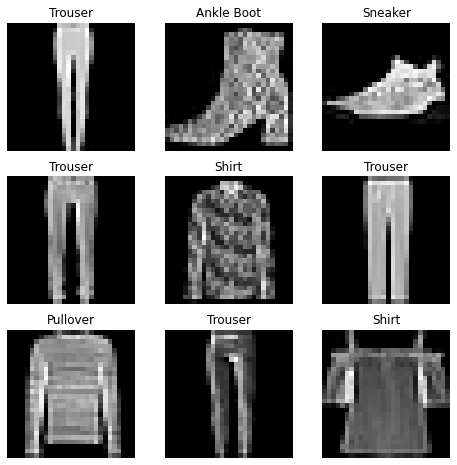

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1) :
    sample_idx = torch.randint(len(traing_data), size=(1,)).item()
    #print(sample_idx)
    img, label = traing_data[sample_idx]
    print(label)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

- labels_map이라는 딕셔너리를 만들어서 10가지 의류에 대한 라벨링을 해준다.
- figure생성 : plt.figure(figsize=(8,8)) 최초의 창의 크기를 가로, 세로 9인치로 설정

***
**3.Creating a Custom Dataset for my files**
- 커스텀 데이터셋 클래스에는 필수적인 메서드 3가지가 존재한다.
- __init__, __len__, __getitem__

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

In [ ]:
class CustomImageDataset(Dataset) :
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None) :
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self) :
        return len(self.img_labels)
    
    def __getitem__(self, idx) :
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform :
            image = self.transform(image)
        if self.target_transform :
            label = self.target_transform(image)
        return image, label
        

1. "__init__"
- init함수는 데이터셋 객체가 생성될 때 한 번만 실행된다.
- 이미지와 주석 파일(annotation file)이 포함된 디렉토리와 transform여부에 대해서 초기화한다. </br>

2. "__len__"
- len함수는 데이터셋의 샘플의 수를 반환해준다.</br>

3. "__getitem__"
- getitem함수는 주어진 인덱스의 데이터셋에서 샘플을 로드하고 반환한다.
- 인덱스를 기반으로 디스크에서 이미지의 경로를 식별하고, read_image를 이용하여 이미지를 텐서로 변환한다.
- self.img_labels의 csv데이터에서 해당 레이블을 검색하고, 변환 함수를 호출한다.
- 마지막으로 텐서 이미지와 레이블을 튜플 형태로 반환한다.

***
## Neural Network build하기
> 아래의 과정에 따라 FashionMNIST dataset을 classify하는 NN을 만들어보자

In [6]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


**1.Define the Class**

In [15]:
class NeuralNetwork(nn.Module) :
    def __init__(self) :
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x) :
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [16]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


- 우리는 nn.Module을 서브클래싱하며 NN을 정의했다.
- 또한, init메서드를 통해 NN layers를 초기화했다.
- 서브클래스인 nn.Module은 foward메서드의 입력 데이터에 대한 작동을 구현한다.

In [17]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([7], device='cuda:0')


***
**2.Model Layers**


In [18]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


***nn.Flatten***

In [19]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


- 입력 이미지로 크기가 28x28인 3개의 이미지를 넣어주고 NN을 거치며 어떠한 작업을 하는지 살펴보자.
- nn.Flatten()을 통해 각 2D 28x28 크기의 이미지를 784픽셀 값의 연속적인 배열로 변환하였다.

***nn.Linear***

In [20]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


- linear layer는 저장된 weights와 biases를 통해 입력 데이터를 선형변환해주는 모듈이다.
- in_features와 out_features를 통해 선형변환되어 출력되는 데이터의 사이즈를 설정할 수 있다. 

***nn.ReLU***

In [21]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.3977, -0.0208,  0.5046, -0.0899, -0.0299,  0.3519,  0.3031,  0.2334,
          0.5376,  0.1759,  0.4335, -0.1988, -0.2429,  0.0917,  0.3385,  0.0452,
         -0.6041, -0.0282, -0.1894, -0.1877],
        [-0.3105,  0.3763,  0.1780, -0.0888, -0.4974,  0.6581,  0.0194,  0.3101,
          0.3727,  0.2632,  0.3790, -0.3889,  0.0946,  0.3487,  0.9028, -0.2882,
         -0.2788,  0.1352, -0.4593, -0.2575],
        [-0.1608, -0.0706,  0.8258, -0.1192, -0.2787,  0.0866, -0.2702,  0.5498,
          0.6251,  0.2181,  0.2677,  0.3032, -0.1124,  0.1185,  0.6639,  0.2472,
         -0.0736,  0.2926, -0.9189, -0.2041]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.5046, 0.0000, 0.0000, 0.3519, 0.3031, 0.2334, 0.5376,
         0.1759, 0.4335, 0.0000, 0.0000, 0.0917, 0.3385, 0.0452, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.3763, 0.1780, 0.0000, 0.0000, 0.6581, 0.0194, 0.3101, 0.3727,
         0.2632, 0.3790, 0.0000, 0.0946, 0.3487, 0.90

- 비선형 활성화는 모델의 입력과 출력사이에 복잡하 maping을 만드는 작업이다.
- 비선형성을 도입하기 위해서 선형변환 후에 적용되어 신경망이 다양한 현상을 학습하도록 하는 것이다.

***nn.Sequential***

In [22]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)

input_image = torch.rand(3, 28, 28)
logits = seq_modules(input_image)

- nn.Sequential은 순서가 지정된 모듈 컨테이너이다.
- 데이터는 정의된 것과 동일한 순서로 모든 모듈을 통해 전달된다.
- 순차 컨테이너를 사용하여 seq_modules와 같은 빠른 네트워크를 구성할 수 있다.

***nn.Softmax***

In [23]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

- 신경망의 마지막 선형 계층은 nn.Softmax 모듈로 전달되는 [-infty, infty]의 원시 값인 logits을 반환한다.
- logits은 각 클래스에 대한 모델의 예측 확률을 나타내는 값 [0, 1]로 조정된다.
- dim매개변수는 값의 합이 1이 되어야 하는 차원을 나타낸다.

***
**3.Model Parameters**

In [24]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters() :
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[-0.0166, -0.0266, -0.0230,  ...,  0.0009,  0.0160, -0.0075],
        [ 0.0308,  0.0283,  0.0135,  ..., -0.0150,  0.0100,  0.0042]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([0.0331, 0.0102], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[-0.0134, -0.0315,  0.0105,  ...,  0.0188, -0.0275,  0.0174],
        [-0.0200,  0.0100, -0.0276,  ..., -0.0368, -0.0359,  0.0181]],
       device='cuda:0', grad_fn=<SliceBa

- 신경망 내부의 많은 layer들은 매개변수화 되어 있다.
- 즉, 훈련 중에 최적화되는 관련 가중치 및 편향이 존재한다.
- nn.Module을 서브클래싱하면 모델 객체 내부에 정의된 모든 필드를 자동으로 추적하고, 모델의 parameters() 또는 named_parameters() 메서드를 사용하여 모든 매개변수에 액세스 할 수 있다.

***
## Optimizing Model Parameters
> 이제 모델과 데이터가 있으므로 데이터에 대한 매개변수를 최적화하여 모델을 훈련, 검증할 차례이다.

- 모델의 학습은 반복적인 과정이다.
- 각 반복에서 모데은 출력에 대해 추측하고, 추측에서 오류(손실)을 계산하고 매개변수와 관련하여 손실의 미분을 수집하고 경사하강법을 통하여 이러한 매개변수를 최적화한다.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [16]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [9]:
class NeuralNetwork(nn.Module) :
    def __init__(self) :
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x) :
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

**Hyperparameter**
- 하이퍼파라미터는 모델 최적화 과정을 제어할 수 있는 조절 가능한 매개변수이다.
- 서로 다른 하이퍼파라미터값은 모델 학습과 수렴율에 영향을 미칠 수 있다.
- 학습 시에 정의하는 하이퍼파라미터를 알아보자.
    - 1. 에폭(epoch)수 : 데이터셋을 반복하는 횟수
    - 2. 배치 크기(batch size) : 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수
    - 3. 학습률(learning rate) : 각 배치/에폭에서 모델의 매개변수를 조절하는 비율. 값이 작을수록 학습 속도가 느려지고, 값이 크면 학습 중 예측할 수 없는 동작이 발생할 수 있다.

In [4]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

**Optimization Loop 최적화 단계**
- 하이퍼파라미터를 설정한 뒤에는 최적화 단계를 통해 모델을 학습하고 최적화할 수 있다.
- 최적화 단계의 각 반복을 '에폭'이라고 한다.
- 하나의 에폭은 다음 두 부분으로 구성된다.
    - 학습 단계 : 학습용 데이터셋을 반복하고 최적의 매개변수로 수렴한다.
    - 검증/테스트 단계 : 모델 성능이 개선되고 있는지를 확인하기 위해 테스트 데이터셋을 반복한다.

**Loss function 손실 함수**
- 학습용 데이터를 제공하면 학습되지 않은 신경망은 정답을 제공하지 않을 확률이 높다. '손실 함수'는 획득한 결과와 실제 값 사이의 틀린 정도를 측정하며, 학습 중에 이 값을 최소화하려고 한다.
- 주어진 데이터 샘플을 입력으로 계산한 예측과 정답을 비교하여 손실을 계산한다.


In [5]:
loss_fn = nn.CrossEntropyLoss()

**Optimizer**
- 최적화는 각 학습 단계에서 모델의 오류를 줄이기 위해 모델 매개변수를 조정하는 과정이다.
- 최적화 알고리즘은 이 과정이 수행되는 방식(여기서는 SGD:경사하강법)을 정의한다.
- 학습하려는 모델의 매개변수와 학습률 하이퍼파라미터를 등록하여 옵티마이저를 초기화한다.

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

- 학습 단계에서 최적화는 3단계로 이루어진다.
    - optimzer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정한다. 기본적으로 변화도는 더해지기 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정해준다.
    - loss.backward()를 호출하여 예측 손실을 역전파한다. PyTorch는 각 매개변수에 대한 손실의 변화도를 저장한다.
    - 변화도를 계산한 뒤에는 optimzer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정한다.

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer) :
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader) :
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()                  
        optimizer.step()
        
        if batch % 100 == 0 :
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn) :
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad() :
        for X, y in dataloader :
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
from tqdm import tqdm

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in tqdm(range(epochs)) :
    print(f"Epoch {t+1}\n--------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
--------------------------
loss: 0.948649 [    0/60000]
loss: 0.976848 [ 6400/60000]
loss: 0.779725 [12800/60000]
loss: 0.951289 [19200/60000]
loss: 0.835124 [25600/60000]
loss: 0.855829 [32000/60000]
loss: 0.913115 [38400/60000]
loss: 0.865771 [44800/60000]
loss: 0.896642 [51200/60000]
loss: 0.844718 [57600/60000]


 10%|█         | 1/10 [00:12<01:48, 12.07s/it]

Test Error: 
 Accuracy: 68.3%, Avg loss: 0.853855 

Epoch 2
--------------------------
loss: 0.881526 [    0/60000]
loss: 0.926738 [ 6400/60000]
loss: 0.718623 [12800/60000]
loss: 0.903146 [19200/60000]
loss: 0.794074 [25600/60000]
loss: 0.804934 [32000/60000]
loss: 0.872765 [38400/60000]
loss: 0.831252 [44800/60000]
loss: 0.854689 [51200/60000]
loss: 0.809087 [57600/60000]


 20%|██        | 2/10 [00:24<01:39, 12.39s/it]

Test Error: 
 Accuracy: 69.6%, Avg loss: 0.815674 

Epoch 3
--------------------------
loss: 0.827917 [    0/60000]
loss: 0.887042 [ 6400/60000]
loss: 0.670959 [12800/60000]
loss: 0.866337 [19200/60000]
loss: 0.763026 [25600/60000]
loss: 0.765714 [32000/60000]
loss: 0.840114 [38400/60000]
loss: 0.805557 [44800/60000]
loss: 0.821995 [51200/60000]
loss: 0.780709 [57600/60000]


 30%|███       | 3/10 [00:37<01:28, 12.71s/it]

Test Error: 
 Accuracy: 70.9%, Avg loss: 0.785367 

Epoch 4
--------------------------
loss: 0.783316 [    0/60000]
loss: 0.854003 [ 6400/60000]
loss: 0.632451 [12800/60000]
loss: 0.837207 [19200/60000]
loss: 0.738201 [25600/60000]
loss: 0.734786 [32000/60000]
loss: 0.812227 [38400/60000]
loss: 0.785130 [44800/60000]
loss: 0.795411 [51200/60000]
loss: 0.757218 [57600/60000]


 40%|████      | 4/10 [00:49<01:14, 12.40s/it]

Test Error: 
 Accuracy: 72.2%, Avg loss: 0.760204 

Epoch 5
--------------------------
loss: 0.745310 [    0/60000]
loss: 0.825201 [ 6400/60000]
loss: 0.600467 [12800/60000]
loss: 0.813539 [19200/60000]
loss: 0.717568 [25600/60000]
loss: 0.709841 [32000/60000]
loss: 0.787605 [38400/60000]
loss: 0.768092 [44800/60000]
loss: 0.773002 [51200/60000]
loss: 0.737087 [57600/60000]


 50%|█████     | 5/10 [01:01<01:01, 12.25s/it]

Test Error: 
 Accuracy: 73.1%, Avg loss: 0.738543 

Epoch 6
--------------------------
loss: 0.712306 [    0/60000]
loss: 0.799343 [ 6400/60000]
loss: 0.573273 [12800/60000]
loss: 0.793713 [19200/60000]
loss: 0.699899 [25600/60000]
loss: 0.689300 [32000/60000]
loss: 0.765156 [38400/60000]
loss: 0.753190 [44800/60000]
loss: 0.753974 [51200/60000]
loss: 0.719314 [57600/60000]


 60%|██████    | 6/10 [01:13<00:48, 12.16s/it]

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.719429 

Epoch 7
--------------------------
loss: 0.683429 [    0/60000]
loss: 0.775863 [ 6400/60000]
loss: 0.549706 [12800/60000]
loss: 0.776568 [19200/60000]
loss: 0.684579 [25600/60000]
loss: 0.672090 [32000/60000]
loss: 0.744454 [38400/60000]
loss: 0.739966 [44800/60000]
loss: 0.737548 [51200/60000]
loss: 0.703389 [57600/60000]


 70%|███████   | 7/10 [01:25<00:36, 12.12s/it]

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.702224 

Epoch 8
--------------------------
loss: 0.657863 [    0/60000]
loss: 0.754383 [ 6400/60000]
loss: 0.529030 [12800/60000]
loss: 0.761500 [19200/60000]
loss: 0.671114 [25600/60000]
loss: 0.657437 [32000/60000]
loss: 0.725268 [38400/60000]
loss: 0.728057 [44800/60000]
loss: 0.723183 [51200/60000]
loss: 0.688926 [57600/60000]


 80%|████████  | 8/10 [01:37<00:24, 12.11s/it]

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.686550 

Epoch 9
--------------------------
loss: 0.635095 [    0/60000]
loss: 0.734727 [ 6400/60000]
loss: 0.510765 [12800/60000]
loss: 0.747927 [19200/60000]
loss: 0.659308 [25600/60000]
loss: 0.644766 [32000/60000]
loss: 0.707381 [38400/60000]
loss: 0.717291 [44800/60000]
loss: 0.710521 [51200/60000]
loss: 0.675653 [57600/60000]


 90%|█████████ | 9/10 [01:49<00:12, 12.08s/it]

Test Error: 
 Accuracy: 76.1%, Avg loss: 0.672185 

Epoch 10
--------------------------
loss: 0.614841 [    0/60000]
loss: 0.716672 [ 6400/60000]
loss: 0.494499 [12800/60000]
loss: 0.735538 [19200/60000]
loss: 0.649016 [25600/60000]
loss: 0.633802 [32000/60000]
loss: 0.690645 [38400/60000]
loss: 0.707661 [44800/60000]
loss: 0.699479 [51200/60000]
loss: 0.663378 [57600/60000]


100%|██████████| 10/10 [02:01<00:00, 12.18s/it]

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.658981 

Done!
